In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qnmfits

As shown in [Cheung et al.](https://arxiv.org/abs/2208.07374) and [Mitman et al.](https://arxiv.org/abs/2208.07380), nonlinear quasinormal modes can be measured in the $(4,4)$ mode of SXS waveforms.

The `qnmfits` package allows nonlinear QNMs to be included in the fit. To do so, provide a tuple of the form

$$ (\ell_0, m_0, n_0, \pm_0, \ell_1, m_1, n_1, \pm_1, \ldots). $$

This will include a mode with frequency

$$ \omega = \omega_{\ell_0 m_0 n_0 \pm_0} + \omega_{\ell_1 m_1 n_1 \pm_1} + \ldots. $$

### Example fit to the $h_{44}$ mode

In [2]:
sim = qnmfits.SXS(305, zero_time=(2,2))

Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


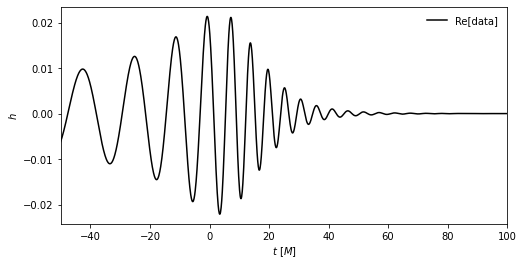

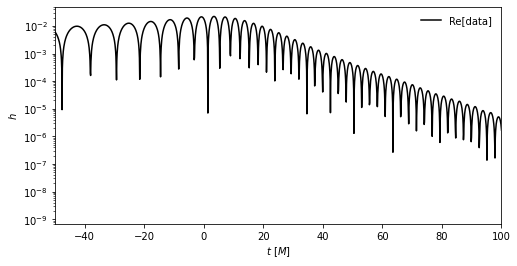

In [3]:
qnmfits.plot_ringdown(sim.times, sim.h[4,4])
qnmfits.plot_ringdown(sim.times, sim.h[4,4], log=True)

Perform a fit $20\ M$ after the time of peak strain with the $(4,4,0)$, $(4,4,1)$, and $(2,2,0) \times (2,2,0)$ quadratic mode (which has frequency $2\omega_{220}$).

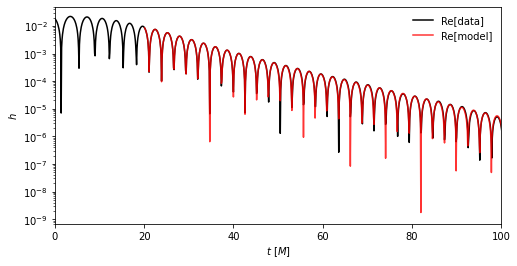

In [4]:
best_fit = qnmfits.ringdown_fit(
    sim.times, 
    sim.h[4,4], 
    modes=[(4,4,0,1),(4,4,1,1),(2,2,0,1,2,2,0,1)],
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=20
)

qnmfits.plot_ringdown(
    sim.times, 
    sim.h[4,4], 
    xlim=[0,100],
    best_fit=best_fit,
    log=True
)

We can also filter out the linear modes using the rational filter developed in [Ma et al.](https://arxiv.org/abs/2207.10870). This will leave us with the quadratic frequency, which we can fit to:

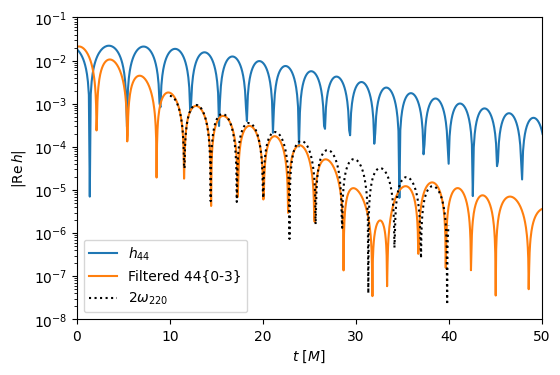

In [5]:
t_filtered, h_filtered = qnmfits.rational_filter(
    sim.times, 
    sim.h[4,4], 
    modes=[(4,4,0,1), (4,4,1,1), (4,4,2,1), (4,4,3,1)], 
    Mf=sim.Mf, 
    chif=sim.chif_mag
)

best_fit = qnmfits.ringdown_fit(
    t_filtered, 
    h_filtered, 
    modes=[(2,2,0,1,2,2,0,1)],
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=10,
    T=30
)

fig, ax = plt.subplots(dpi=100)

ax.plot(sim.times, abs(np.real(sim.h[4,4])), label=r'$h_{44}$')
ax.plot(t_filtered, np.abs(np.real(h_filtered)), label='Filtered 44{0-3}')
ax.plot(best_fit['model_times'], abs(np.real(best_fit['model'])), 'k:', label=r'$2\omega_{220}$')

ax.set_xlim(0, 50)
ax.set_ylim(1e-8, 1e-1)

ax.set_yscale('log')

ax.set_xlabel('$t\ [M]$')
ax.set_ylabel('$|\mathrm{Re}\,h|$')

_ = ax.legend(loc='lower left')

We can fit a free frequency to the data, and see how well it agrees with the predicted quadratic frequency.

In [6]:
# We fit for the (4,4,0) QNM using the Kerr prediction. On top of this, we fit
# for a free frequency.
omega_bestfit = qnmfits.free_frequency_fit(
    sim.times, 
    sim.h[4,4], 
    modes=[(4,4,0,1)], 
    Mf=sim.Mf, 
    chif=sim.chif_mag,
    t0=25
)

# We expect to find something close to the quadratic frequency, omega_target
omega_target = 2*qnmfits.qnm.omega(2, 2, 0, 1, sim.chif_mag, sim.Mf)

We can quantify the "distance" between two frequencies using the below function, taken from [Cheung et al.](https://arxiv.org/abs/2208.07374).

In [7]:
def delta_omega(omega_fit, omega_target):
    
    r_fit = np.real(omega_fit)
    i_fit = np.imag(omega_fit)
    
    r_target = np.real(omega_target)
    i_target = np.imag(omega_target)
    
    return np.sqrt(((r_fit-r_target)/r_target)**2 + ((i_fit-i_target)/i_target)**2)

In [8]:
delta_omega(omega_bestfit, omega_target)

0.0534995925607527

Repeat for a range of start times to reproduce the second-row panel of Fig. 1 in [Cheung et al.](https://arxiv.org/abs/2208.07374).

In [9]:
omega_fit_list_n0 = []
t0_list = np.linspace(10, 35)

for t0 in t0_list:
    omega_fit_list_n0.append(qnmfits.free_frequency_fit(
        sim.times, 
        sim.h[4,4], 
        modes=[(4,4,0,1)], 
        Mf=sim.Mf, 
        chif=sim.chif_mag,
        t0=t0
    ))
    
omega_fit_list_n0 = np.array(omega_fit_list_n0)

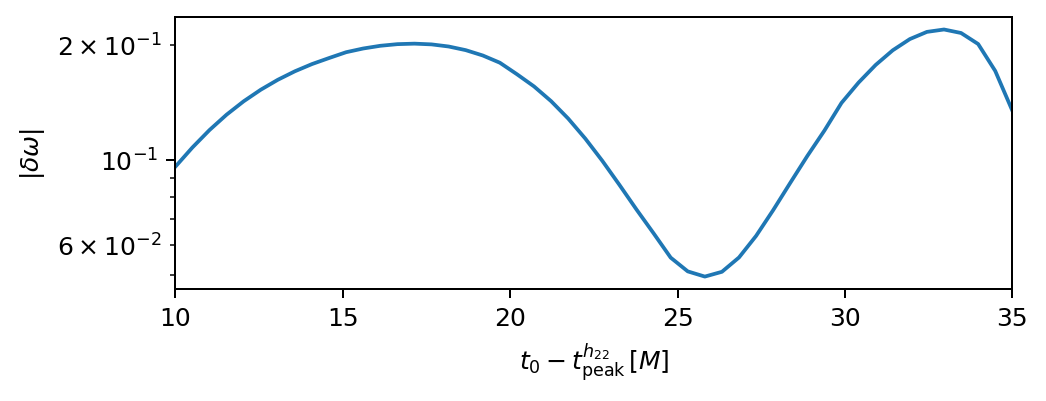

In [10]:
fig, ax = plt.subplots(figsize=(6,2), dpi=180)

ax.plot(t0_list, delta_omega(omega_fit_list_n0, omega_target))

ax.set_yscale('log')

ax.set_xlim(t0_list[0], t0_list[-1])

ax.set_xlabel('$t_0 - t_\mathrm{peak}^{h_{22}}\, [M]$')
_ = ax.set_ylabel('$|\delta \omega|$')

Including the (4,4,1) mode in our fit as well...

In [11]:
omega_fit_list_n1 = []
t0_list = np.linspace(10, 35)

for t0 in t0_list:
    omega_fit_list_n1.append(qnmfits.free_frequency_fit(
        sim.times, 
        sim.h[4,4], 
        modes=[(4,4,0,1),(4,4,1,1)], 
        Mf=sim.Mf, 
        chif=sim.chif_mag,
        t0=t0
    ))
    
omega_fit_list_n1 = np.array(omega_fit_list_n1)

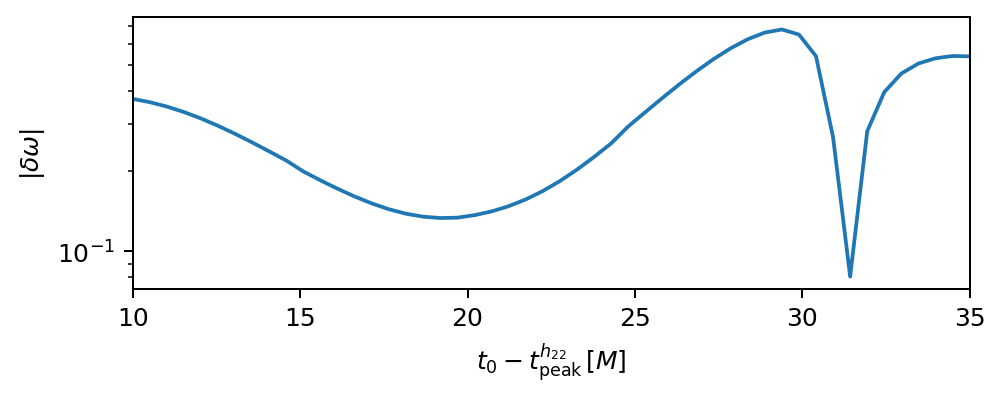

In [12]:
fig, ax = plt.subplots(figsize=(6,2), dpi=180)

ax.plot(t0_list, delta_omega(omega_fit_list_n1, omega_target))

ax.set_yscale('log')

ax.set_xlim(t0_list[0], t0_list[-1])

ax.set_xlabel('$t_0 - t_\mathrm{peak}^{h_{22}}\, [M]$')
_ = ax.set_ylabel('$|\delta \omega|$')

Do things change if we use a superrest frame waveform? **Ask 

In [13]:
import pickle
import json

filename = 'SXS:BBH_ExtCCE_superrest:0305'

with open(f'{filename}.pickle', 'rb') as f:
    strain_data = pickle.load(f)
times = strain_data.pop('times')

with open(f'{filename}_metadata.json', 'r') as f:
    metadata = json.load(f)
    
sim_CCE = qnmfits.Custom(times, strain_data, metadata, zero_time=(2,2))

In [14]:
omega_fit_list_CCE_n0 = []
t0_list = np.linspace(10, 35)

for t0 in t0_list:
    omega_fit_list_CCE_n0.append(qnmfits.free_frequency_fit(
        sim_CCE.times, 
        sim_CCE.h[4,4], 
        modes=[(4,4,0,1)], 
        Mf=sim_CCE.Mf, 
        chif=sim_CCE.chif_mag,
        t0=t0
    ))
    
omega_fit_list_CCE_n0 = np.array(omega_fit_list_CCE_n0)

In [15]:
omega_fit_list_CCE_n1 = []
t0_list = np.linspace(10, 35)

for t0 in t0_list:
    omega_fit_list_CCE_n1.append(qnmfits.free_frequency_fit(
        sim_CCE.times, 
        sim_CCE.h[4,4], 
        modes=[(4,4,0,1),(4,4,1,1)], 
        Mf=sim_CCE.Mf, 
        chif=sim_CCE.chif_mag,
        t0=t0
    ))
    
omega_fit_list_CCE_n1 = np.array(omega_fit_list_CCE_n1)

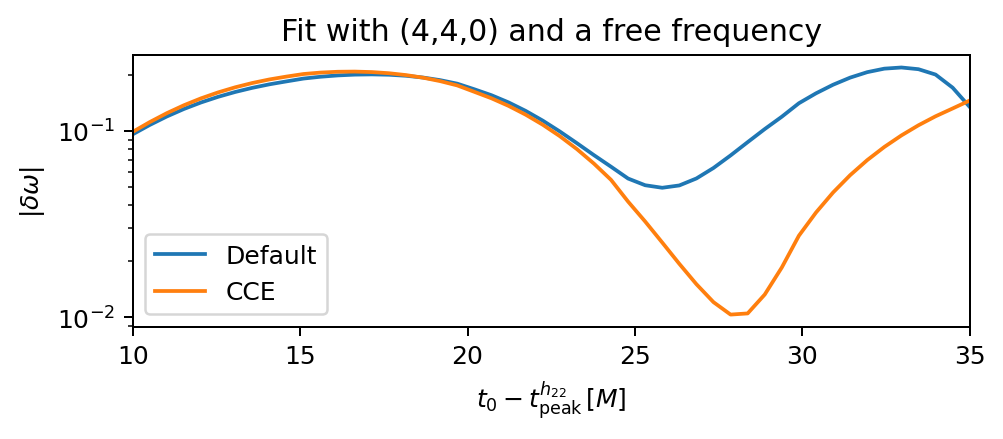

In [16]:
fig, ax = plt.subplots(figsize=(6,2), dpi=180)

ax.plot(t0_list, delta_omega(omega_fit_list_n0, omega_target), label='Default')
ax.plot(t0_list, delta_omega(omega_fit_list_CCE_n0, omega_target), label='CCE')

ax.set_yscale('log')

ax.set_xlim(t0_list[0], t0_list[-1])

ax.set_title('Fit with (4,4,0) and a free frequency')
ax.set_xlabel('$t_0 - t_\mathrm{peak}^{h_{22}}\, [M]$')
ax.set_ylabel('$|\delta \omega|$')

_ = ax.legend()

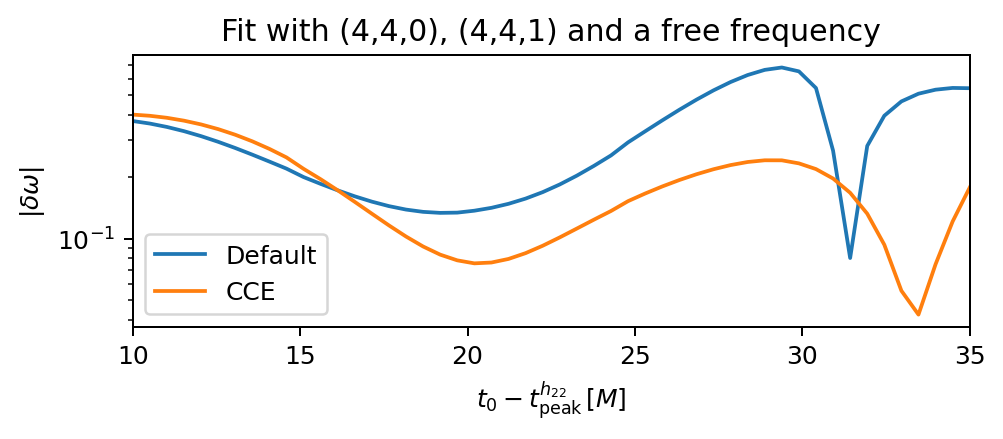

In [17]:
fig, ax = plt.subplots(figsize=(6,2), dpi=180)

ax.plot(t0_list, delta_omega(omega_fit_list_n1, omega_target), label='Default')
ax.plot(t0_list, delta_omega(omega_fit_list_CCE_n1, omega_target), label='CCE')

ax.set_xlim(t0_list[0], t0_list[-1])

ax.set_yscale('log')

ax.set_title('Fit with (4,4,0), (4,4,1) and a free frequency')
ax.set_xlabel('$t_0 - t_\mathrm{peak}^{h_{22}}\, [M]$')
ax.set_ylabel('$|\delta \omega|$')

_ = ax.legend()

We can plot the path the bestfit complex frequency takes in the complex plane as a function of start time (i.e. the top row of Fig. 1 from [Cheung et al.](https://arxiv.org/abs/2208.07374)).

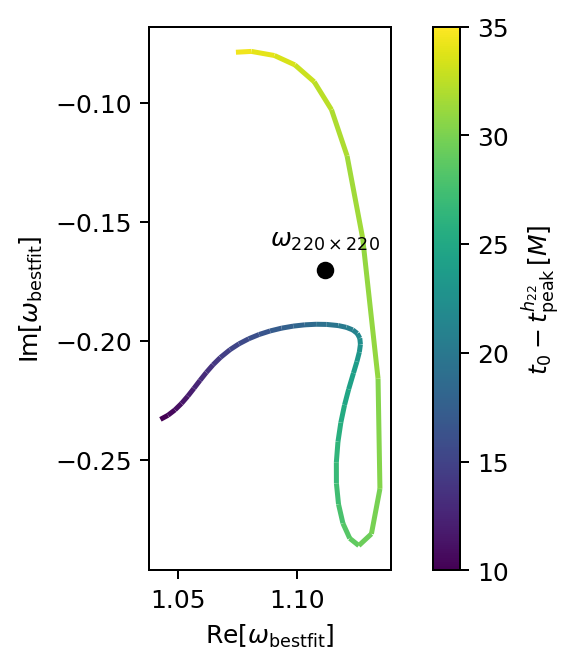

In [18]:
# Apply a cmap to a line by splitting the line up into segments. Taken from
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html

from matplotlib.collections import LineCollection

x = np.real(omega_fit_list_n1)
y = np.imag(omega_fit_list_n1)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(dpi=180)
ax.set_aspect('equal')

norm = plt.Normalize(min(t0_list), max(t0_list))
lc = LineCollection(segments, cmap='viridis', norm=norm)
lc.set_array(t0_list)

lc.set_linewidth(2)
line = ax.add_collection(lc)
cbar = fig.colorbar(line, ax=ax)
cbar.ax.set_ylabel('$t_0 - t_\mathrm{peak}^{h_{22}}\, [M]$')

ax.plot(np.real(omega_target), np.imag(omega_target), 'o', c='k')
ax.text(
    np.real(omega_target), 
    np.imag(omega_target)+0.01, 
    r'$\omega_{220 \times 220}$', 
    horizontalalignment='center'
    )

ax.set_xlabel('$\mathrm{Re}[\omega_\mathrm{bestfit}]$')
_ = ax.set_ylabel('$\mathrm{Im}[\omega_\mathrm{bestfit}]$')